# Portfolio Optimization Strategies
**Prepared by:** Adisorn Promkaewngarm

# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
from sklearn.covariance import LedoitWolf
import time

## Functions

In [2]:
def get_optimal_mvo_weights(window_ret, lambda_val=1, ann_factor=52):
    """
    Revised Static MVO (Benchmark):
    - Strict 5% cap for ALL assets (including Gold and RiskFree)
    - Enforces maximum diversification (minimum of 20 assets)
    - Ledoit-Wolf Shrunk Covariance
    """
    # 1. Identify assets with complete data
    clean_window = window_ret.dropna(axis=1)
    available_assets = clean_window.columns.tolist()
    n_clean = len(available_assets)

    # Initialize result series with 0.0
    final_weights_series = pd.Series(0.0, index=window_ret.columns)

    if n_clean == 0:
        return final_weights_series.values

    # 2. Calculate Mean and Ledoit-Wolf Shrunk Covariance
    mu = clean_window.mean().values * ann_factor
    lw = LedoitWolf()
    Sigma_shrunk = lw.fit(clean_window).covariance_ * ann_factor

    # 3. Optimization Setup
    w_cvx = cvx.Variable(n_clean)

    # 4. Define Constraints: Strict 5% for everything
    constraints = [
        cvx.sum(w_cvx) == 1,
        w_cvx >= 0,
        w_cvx <= 0.05  # Force 5% max for ALL assets
    ]

    # 5. Objective: Maximize Risk-Adjusted Utility
    risk = cvx.quad_form(w_cvx, cvx.psd_wrap(Sigma_shrunk))
    objective = cvx.Maximize(mu @ w_cvx - 0.5 * lambda_val * risk)

    # 6. Solve
    prob = cvx.Problem(objective, constraints)
    try:
        prob.solve(solver=cvx.OSQP)
        if w_cvx.value is None:
            active_weights = np.ones(n_clean) / n_clean
        else:
            active_weights = w_cvx.value
    except:
        active_weights = np.ones(n_clean) / n_clean

    # 7. Map weights back
    for i, asset_name in enumerate(available_assets):
        final_weights_series[asset_name] = active_weights[i]

    return final_weights_series.values

In [3]:
def get_equal_weight_weights(window_ret):
    """
    Computes Equal Weight (EW) weights by only considering
    assets that have full data in the current window.
    """
    # 1. Identify assets with complete data (no NaNs)
    # This matches the logic used in your MVO function
    clean_window = window_ret.dropna(axis=1)
    available_assets = clean_window.columns.tolist()
    n_clean = len(available_assets)

    # Initialize a result series with 0.0 for ALL original assets
    final_weights_series = pd.Series(0.0, index=window_ret.columns)

    if n_clean > 0:
        # 2. Distribute 100% weight equally among available assets
        ew_value = 1.0 / n_clean
        for asset_name in available_assets:
            final_weights_series[asset_name] = ew_value

    # Return as a numpy array in the EXACT order of window_ret.columns
    return final_weights_series.values

In [4]:
def get_dynamic_mvo_weights(window_ret, lambda_val, regime):
    """
    Finalized Strategic Logic:
    - Regime 1 (Bear): Gold <= 20%, TOTAL Stocks <= 10%, Risk-Free takes remainder (min 70%).
    - Regime 2 (Bull): Gold <= 5%, Risk-Free <= 5%, Individual Stocks <= 10% (High Conviction).
    - Regime 0 (Neutral): all Assets (Stocks/Gold) <= 5%, Risk-Free <= 100%.
    """
    # 1. Ensure regime is an integer
    try:
        regime = int(regime)
    except:
        regime = 0

    # 2. Data Preparation
    clean_window = window_ret.dropna(axis=1)
    assets = clean_window.columns.tolist()
    n = len(assets)

    if n == 0:
        return np.zeros(len(window_ret.columns))

    # 3. Calculate Mean and Ledoit-Wolf Shrunk Covariance
    mu = clean_window.mean().values
    lw = LedoitWolf()
    Sigma_shrunk = lw.fit(clean_window).covariance_

    # 4. Variables and Base Constraints
    w = cvx.Variable(n)
    constraints = [cvx.sum(w) == 1, w >= 0]

    # Identify indices for stocks
    stock_indices = [i for i, name in enumerate(assets) if name not in ['GLD.BK', 'RiskFree_Rate']]

    # 5. Define Regime-Specific Constraints
    for i, asset_name in enumerate(assets):
        if regime == 1:  # --- BEAR MARKET ---
            if asset_name == 'GLD.BK':
                constraints.append(w[i] <= 0.20)  # Gold cap 20%
            elif asset_name == 'RiskFree_Rate':
                constraints.append(w[i] <= 1.00)
            else:
                constraints.append(w[i] <= 0.05)  # Individual stock cap

        elif regime == 2:  # --- BULL MARKET ---
            if asset_name == 'GLD.BK' or asset_name == 'RiskFree_Rate':
                constraints.append(w[i] <= 0.05)  # Defensive limited to 5%
            else:
                constraints.append(w[i] <= 0.10)  # High conviction stock cap

        else:  # --- NEUTRAL MARKET ---
            if asset_name == 'RiskFree_Rate':
                constraints.append(w[i] <= 1.00)  # Cash remains the flexible buffer
            else:
                # Gold and Stocks are treated equally here (max 5% each)
                constraints.append(w[i] <= 0.05)

    # 6. Apply TOTAL Stock Constraint specifically for BEAR Market
    if regime == 1 and len(stock_indices) > 0:
        constraints.append(cvx.sum(w[stock_indices]) <= 0.10)

    # 7. Objective: Maximize Risk-Adjusted Utility
    risk = cvx.quad_form(w, cvx.psd_wrap(Sigma_shrunk))
    objective = cvx.Maximize(mu @ w - 0.5 * lambda_val * risk)

    # 8. Solve
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver=cvx.OSQP)

    # 9. Map weights back
    final_weights = pd.Series(0.0, index=window_ret.columns)
    if w.value is not None:
        final_weights[assets] = w.value

    return final_weights.values

# Import Data

Regime
{0: Sideways, 1: Bear, 2:Bull}

In [5]:
# 1. DEFINE RAW GITHUB PATHS
base_url = "https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/"

path_ret = base_url + "df_all_assets_log_ret_weekly.csv"
path_set = base_url + "SET_Index_Weekly_2010_2025.csv"
path_stack_train = "https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/Capstone%20Project%20Code/Robustness%20Tests/TruncatedLags/stack_regime_preds_train.csv"
path_stack_test  = "https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/Capstone%20Project%20Code/Robustness%20Tests/TruncatedLags/stack_regime_preds_test.csv"
path_voter_train = "https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/Capstone%20Project%20Code/Robustness%20Tests/TruncatedLags/vote_regime_preds_train.csv"
path_voter_test  = "https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/Capstone%20Project%20Code/Robustness%20Tests/TruncatedLags/vote_regime_preds_test.csv"

# 2. LOAD ASSET RETURNS
df_returns = pd.read_csv(path_ret, index_col='Date', parse_dates=True) # Log returns
  # Convert the entire log return dataframe to simple returns for portfolio optimization
df_returns_simple = np.exp(df_returns) - 1

  # Train-Test Split
df_returns_train = df_returns.loc['2011':'2022'] # Train: 2011 to 2022
df_returns_test  = df_returns.loc['2023':] # Test: 2023 onwards

# 3. LOAD REGIME PREDICTIONS
# Stacking Models
df_stack_train = pd.read_csv(path_stack_train, index_col='Date', parse_dates=True)
df_stack_test  = pd.read_csv(path_stack_test, index_col='Date', parse_dates=True)

# Voting Models
df_voter_train = pd.read_csv(path_voter_train, index_col='Date', parse_dates=True)
df_voter_test  = pd.read_csv(path_voter_test, index_col='Date', parse_dates=True)

# 4. # Load SET Index and calculate simple returns
df_set_index = pd.read_csv(path_set, index_col='Date', parse_dates=True)

In [6]:
# Check Training Alignment
train_ok = df_returns_train.index.equals(df_stack_train.index)
print(f"Train Indices Match: {train_ok}")

# Check Testing Alignment
test_ok = df_returns_test.index.equals(df_stack_test.index)
print(f"Test Indices Match:  {test_ok}")

# If they don't match, run this to see the difference in row counts:
if not (train_ok and test_ok):
    print(f"\nRow Counts:")
    print(f"Returns: Train={len(df_returns_train)}, Test={len(df_returns_test)}")
    print(f"Stacking: Train={len(df_stack_train)}, Test={len(df_stack_test)}")

Train Indices Match: True
Test Indices Match:  True


# Traditional MVO

In [7]:
# --- SETTINGS ---
lookback = 104
MVO_full_weights_list = []
full_dates_list = []
target_lambda = 1

# --- EXECUTION ON ENTIRE DATASET ---
start_time = time.time()

print(f"Starting rolling optimization (Static MVO, Lambda={target_lambda}) for {len(df_returns_simple) - lookback} weeks...")
print("-" * 50)

for i in range(lookback, len(df_returns_simple)):
    # Slice the previous 104 weeks
    window = df_returns_simple.iloc[i-lookback:i]
    current_date = df_returns_simple.index[i]

    # Calculate optimal weights using the revised function
    # Note: Asset caps (40% Gold, 5% Stocks) are handled inside the function
    opt_w = get_optimal_mvo_weights(window, lambda_val=target_lambda)

    MVO_full_weights_list.append(opt_w)
    full_dates_list.append(current_date)

    # Progress indicator
    if (i - lookback + 1) % 100 == 0 or (i + 1) == len(df_returns_simple):
        print(f"Week {i - lookback + 1} completed... Elapsed: {time.time() - start_time:.2f}s")

total_duration = time.time() - start_time
print("-" * 50)
print(f"Optimization Finished! Total time: {total_duration:.2f} seconds")

# --- RIGOROUS VERIFICATION ---
print("\nRunning Weight Integrity Verification...")

# Check 1: Alignment Check
weight_vector_len = len(MVO_full_weights_list[0])
return_asset_count = df_returns_simple.shape[1]
print(f"Check 1: Weight vector length ({weight_vector_len}) vs Asset count ({return_asset_count})")

# Check 2: Global Summation Check (Budget Constraint = 1.0)
weights_array = np.array(MVO_full_weights_list)
all_row_sums = np.sum(weights_array, axis=1)
invalid_indices = np.where(~np.isclose(all_row_sums, 1.0, atol=1e-6))[0]

if len(invalid_indices) == 0:
    print("Check 2: Global Sum Check - All weeks sum to 1.0.")
else:
    print(f"Check 2: Global Sum Check - FAILED. Found {len(invalid_indices)} weeks with incorrect sums.")

# Check 3: NaN Check
total_nans = np.isnan(weights_array).sum()
print(f"Check 3: Total NaNs in weights: {total_nans}")

# Check 4: Preview Extremes
print(f"Check 4: Min row sum: {all_row_sums.min():.6f} | Max row sum: {all_row_sums.max():.6f}")

Starting rolling optimization (Static MVO, Lambda=1) for 731 weeks...
--------------------------------------------------
Week 100 completed... Elapsed: 1.31s
Week 200 completed... Elapsed: 3.56s
Week 300 completed... Elapsed: 8.18s
Week 400 completed... Elapsed: 12.98s
Week 500 completed... Elapsed: 19.84s
Week 600 completed... Elapsed: 30.13s
Week 700 completed... Elapsed: 43.93s
Week 731 completed... Elapsed: 49.00s
--------------------------------------------------
Optimization Finished! Total time: 49.00 seconds

Running Weight Integrity Verification...
Check 1: Weight vector length (114) vs Asset count (114)
Check 2: Global Sum Check - All weeks sum to 1.0.
Check 3: Total NaNs in weights: 0
Check 4: Min row sum: 1.000000 | Max row sum: 1.000000


In [8]:
# 1. Create the master Weights DataFrame
df_weights_mvo_all = pd.DataFrame(
    MVO_full_weights_list,
    index=full_dates_list,
    columns=df_returns_simple.columns
)

# 2. Calculate Weekly Portfolio Returns (Element-wise multiplication & sum)
returns_subset_all = df_returns_simple.loc[df_weights_mvo_all.index]
mvo_all_ret = (df_weights_mvo_all * returns_subset_all).sum(axis=1).to_frame(name='MVO_ret')

# 3. Filter for the Research Period (2013 to 2026)
# This results in the final return series for this specific configuration
mvo_full_ret = mvo_all_ret.loc['2013':]

# 4. Final Verification and Preview
print("-" * 40)
print(f"MVO Strategy Return Processing Complete (Unified Period)")
print("-" * 40)
# Corrected variable name in the f-string to match step 3
print(f"Total Data: {len(mvo_full_ret)} weeks")
print(f"Date Range: {mvo_full_ret.index.min().date()} to {mvo_full_ret.index.max().date()}")
print("-" * 40)

----------------------------------------
MVO Strategy Return Processing Complete (Unified Period)
----------------------------------------
Total Data: 678 weeks
Date Range: 2013-01-07 to 2025-12-29
----------------------------------------


In [9]:
mvo_full_ret.index

DatetimeIndex(['2013-01-07', '2013-01-14', '2013-01-21', '2013-01-28',
               '2013-02-04', '2013-02-11', '2013-02-18', '2013-02-25',
               '2013-03-04', '2013-03-11',
               ...
               '2025-10-27', '2025-11-03', '2025-11-10', '2025-11-17',
               '2025-11-24', '2025-12-01', '2025-12-08', '2025-12-15',
               '2025-12-22', '2025-12-29'],
              dtype='datetime64[ns]', length=678, freq=None)

# Equal-Weighted Portfolio

In [10]:
# --- SETTINGS ---
lookback = 104
EW_full_weights_list = []
# (We reuse full_dates_list from your MVO run to ensure alignment)

start_time = time.time()
print(f"Starting rolling Equal Weight calculation for {len(df_returns_simple) - lookback} weeks...")

for i in range(lookback, len(df_returns_simple)):
    window = df_returns_simple.iloc[i-lookback:i]

    # Call the EW function
    weights = get_equal_weight_weights(window)

    EW_full_weights_list.append(weights)

print(f"EW calculation finished in {time.time() - start_time:.2f} seconds.")

# --- 3. AUDIT & VERIFICATION ---
ew_weights_array = np.array(EW_full_weights_list)
ew_sums = np.sum(ew_weights_array, axis=1)

print("-" * 30)
print(f"Weight vector length: {ew_weights_array.shape[1]} (Matches MVO: {ew_weights_array.shape[1] == len(MVO_full_weights_list[0])})")
print(f"Global Sum Check: { 'PASSED' if np.allclose(ew_sums, 1.0) else 'FAILED' }")
print("-" * 30)

Starting rolling Equal Weight calculation for 731 weeks...
EW calculation finished in 0.69 seconds.
------------------------------
Weight vector length: 114 (Matches MVO: True)
Global Sum Check: PASSED
------------------------------


In [11]:
import pandas as pd

# 1. Create the master EW Weights DataFrame
df_weights_ew_all = pd.DataFrame(
    EW_full_weights_list,
    index=full_dates_list,
    columns=df_returns_simple.columns
)

# 2. Calculate Weekly Portfolio Returns
# Align returns to match the weight dates exactly
returns_subset_all = df_returns_simple.loc[df_weights_ew_all.index]

# Compute weighted returns and sum across columns for the full history
ew_all_ret = (df_weights_ew_all * returns_subset_all).sum(axis=1).to_frame(name='EW_ret')

# 3. Filter for the Research Period (2013 to 2026)
# Removing the train-test split for a unified walk-forward view
ew_full_ret = ew_all_ret.loc['2013':]

# 4. Final Verification and Preview
print("-" * 40)
print(f"EW Strategy Return Processing Complete (Unified Period)")
print("-" * 40)
print(f"Total Data: {len(ew_full_ret)} weeks")
print(f"Date Range: {ew_full_ret.index.min().date()} to {ew_full_ret.index.max().date()}")
print("-" * 40)

----------------------------------------
EW Strategy Return Processing Complete (Unified Period)
----------------------------------------
Total Data: 678 weeks
Date Range: 2013-01-07 to 2025-12-29
----------------------------------------


# Buy-and-Hold Stock Index

In [12]:
import pandas as pd

# 1. Compute SET Index Weekly Returns (Open-to-Close)
df_set_index['SET_BH_ret'] = (df_set_index['Close'] / df_set_index['Open']) - 1
BH_port = df_set_index[['SET_BH_ret']].rename(columns={'SET_BH_ret': 'SET_Index_ret'})

# 2. Filter for the Research Period (2013 to 2026)
# Unified period to match the walk-forward logic of your dynamic models
BH_full_ret = BH_port.loc['2013':]

# 3. Specific Period Verification
print("-" * 40)
print(f"BH (SET Index) Strategy Return Processing Complete (Unified)")
print("-" * 40)
print(f"Total Data: {len(BH_full_ret)} weeks")
print(f"Date Range: {BH_full_ret.index.min().date()} to {BH_full_ret.index.max().date()}")
print("-" * 40)

----------------------------------------
BH (SET Index) Strategy Return Processing Complete (Unified)
----------------------------------------
Total Data: 678 weeks
Date Range: 2013-01-07 to 2025-12-29
----------------------------------------


# Dynamic MVO

## Data Preparation

In [13]:
# 1. Merge and Filter Stacking Model Predictions
df_stack_all = pd.concat([df_stack_train, df_stack_test])
df_stack_all.sort_index(inplace=True)
df_stack_all = df_stack_all.loc['2013':] # Filter to start from 2013
df_stack_all = df_stack_all.astype(int) # Convert to int for consistency

# 2. Merge and Filter Voting Model Predictions
df_voter_all = pd.concat([df_voter_train, df_voter_test])
df_voter_all.sort_index(inplace=True)
df_voter_all = df_voter_all.loc['2013':] # Filter to start from 2013
df_voter_all = df_voter_all.astype(int) # Convert to int for consistency

# 3. Final Verification of week counts
print("-" * 40)
print("Ensemble Regimes Merged & Filtered (2013-End)")
print("-" * 40)
print(f"Stacking Strategy: {len(df_stack_all)} weeks")
print(f"Voting Strategy:   {len(df_voter_all)} weeks")

----------------------------------------
Ensemble Regimes Merged & Filtered (2013-End)
----------------------------------------
Stacking Strategy: 678 weeks
Voting Strategy:   678 weeks


In [14]:
# 1. Define the Reference Index from the Returns Data
reference_index = df_returns_simple.loc['2013':].index

# 2. Check Equality (Dates and Length)
stack_match = df_stack_all.index.equals(reference_index)
voter_match = df_voter_all.index.equals(reference_index)

# 3. Print Verification Results
print("Data Alignment Audit: 2013 - End")
print("-" * 45)
print(f"Reference Weeks (Returns): {len(reference_index)}")
print(f"Stacking Weeks:           {len(df_stack_all)}")
print(f"Voting Weeks:             {len(df_voter_all)}")
print("-" * 45)
print(f"Stacking Index Match: {stack_match}")
print(f"Voting Index Match:   {voter_match}")
print("-" * 45)

# 4. Detailed Check (if any mismatch exists)
if not (stack_match and voter_match):
    missing_in_stack = reference_index.difference(df_stack_all.index)
    missing_in_voter = reference_index.difference(df_voter_all.index)
    print(f"Dates in Returns but missing in Stacking: {list(missing_in_stack)}")
    print(f"Dates in Returns but missing in Voter:   {list(missing_in_voter)}")

Data Alignment Audit: 2013 - End
---------------------------------------------
Reference Weeks (Returns): 678
Stacking Weeks:           678
Voting Weeks:             678
---------------------------------------------
Stacking Index Match: True
Voting Index Match:   True
---------------------------------------------


In [15]:
df_stack_all.iloc[:,0].value_counts()

,count
Predicted_Regime,
0,296
1,220
2,162


In [16]:
df_voter_all.iloc[:,0].value_counts()

,count
Predicted_Regime,
0,433
2,147
1,98


## Finding the optimal weight

### Voter Model

In [17]:
# --- Voter Moderate: Get Weights and Rigorous Verification ---
lambda_map_moderate = {0: 1.0, 1: 2.0, 2: 0.5}
voter_weights_moderate_list = []
lookback = 104
dates_list = df_voter_all.index

print(f"Starting Voter Model for {len(dates_list)} weeks...")
print("-" * 50)

# 1. Optimization Loop
for i, date in enumerate(dates_list):
    if (i + 1) % 100 == 0 or (i + 1) == len(dates_list):
        print(f"Processing week {i + 1}/{len(dates_list)}...")

    idx = df_returns_simple.index.get_loc(date)
    window = df_returns_simple.iloc[idx-lookback : idx]

    # Force conversion to integer immediately
    current_regime = int(df_voter_all.loc[date].iloc[0])
    current_lambda = lambda_map_moderate[current_regime]

    try:
        w = get_dynamic_mvo_weights(window, current_lambda, current_regime)
        voter_weights_moderate_list.append(w)
    except Exception as e:
        print(f"Warning: Optimization failed at {date}. Using fallback.")
        fallback = voter_weights_moderate_list[-1] if voter_weights_moderate_list else np.zeros(len(df_returns_simple.columns))
        voter_weights_moderate_list.append(fallback)

print("-" * 50)
print("Running Rigorous Weight Verification...")

# 2. Create the Weights DataFrame
df_voter_weights_moderate = pd.DataFrame(
    voter_weights_moderate_list,
    index=df_voter_all.index,
    columns=df_returns_simple.columns
)

# --- VERIFICATION CHECKS ---

# Check 1: Global Sum Check
weights_array = df_voter_weights_moderate.values
all_row_sums = np.sum(weights_array, axis=1)
if np.allclose(all_row_sums, 1.0, atol=1e-6):
    print("Check 1: Global Sum Check - PASSED (All sum to 1.0)")

# Check 2: Bear Market Stock Exposure (Regime 1)
bear_dates = df_voter_all[df_voter_all.iloc[:,0] == 1].index
if not bear_dates.empty:
    stock_cols = [c for c in df_returns_simple.columns if c not in ['GLD.BK', 'RiskFree_Rate']]
    bear_stock_sum = df_voter_weights_moderate.loc[bear_dates, stock_cols].sum(axis=1).max()
    print(f"Check 2: Bear Market Max Stock Weight: {bear_stock_sum:.6f} (Target: 0.000000)")

# Check 3: Bull Market Asset Caps (Regime 2)
bull_dates = df_voter_all[df_voter_all.iloc[:,0] == 2].index
if not bull_dates.empty:
    max_gold_bull = df_voter_weights_moderate.loc[bull_dates, 'GLD.BK'].max()
    max_rf_bull = df_voter_weights_moderate.loc[bull_dates, 'RiskFree_Rate'].max()
    print(f"Check 3: Bull Market Max Gold: {max_gold_bull:.2%}, Max RiskFree: {max_rf_bull:.2%}")

# --- FINALIZE DATA ---
voter_port_moderate_ret_series = (df_voter_weights_moderate * df_returns_simple.loc[df_voter_all.index]).sum(axis=1)
voter_full_moderate_ret = voter_port_moderate_ret_series.to_frame(name='Voter_Moderate_ret').loc['2013':]

print("-" * 50)
print(f"Voter Moderate Complete: {len(voter_full_moderate_ret)} weeks.")

Starting Voter Model for 678 weeks...
--------------------------------------------------
Processing week 100/678...
Processing week 200/678...
Processing week 300/678...
Processing week 400/678...
Processing week 500/678...
Processing week 600/678...
Processing week 678/678...
--------------------------------------------------
Running Rigorous Weight Verification...
Check 1: Global Sum Check - PASSED (All sum to 1.0)
Check 2: Bear Market Max Stock Weight: 0.100014 (Target: 0.000000)
Check 3: Bull Market Max Gold: 5.00%, Max RiskFree: 0.00%
--------------------------------------------------
Voter Moderate Complete: 678 weeks.


In [18]:
# --- Voter Aggressive: Get Weights and Rigorous Verification ---
# λ=5.0 for Bear (High Risk Aversion), λ=0.1 for Bull (Low Risk Aversion)
lambda_map_aggressive = {0: 1.0, 1: 5.0, 2: 0.1}
voter_weights_aggressive_list = []
lookback = 104
dates_list = df_voter_all.index

print(f"Starting Voter Model (Aggressive Lambda) for {len(dates_list)} weeks...")
print("-" * 50)

# 1. Optimization Loop
for i, date in enumerate(dates_list):
    if (i + 1) % 100 == 0 or (i + 1) == len(dates_list):
        print(f"Processing week {i + 1}/{len(dates_list)}...")

    idx = df_returns_simple.index.get_loc(date)
    window = df_returns_simple.iloc[idx-lookback : idx]

    # Force conversion to integer immediately
    current_regime = int(df_voter_all.loc[date].iloc[0])
    current_lambda = lambda_map_aggressive[current_regime]

    try:
        # Pass regime to enforce Bear/Bull constraints
        w = get_dynamic_mvo_weights(window, current_lambda, current_regime)
        voter_weights_aggressive_list.append(w)
    except Exception as e:
        print(f"Warning: Optimization failed at {date}. Using fallback.")
        fallback = voter_weights_aggressive_list[-1] if voter_weights_aggressive_list else np.zeros(len(df_returns_simple.columns))
        voter_weights_aggressive_list.append(fallback)

print("-" * 50)
print("Running Rigorous Weight Verification (Aggressive Profile)...")

# --- VERIFICATION CHECKS ---

# 2. Create the Weights DataFrame
df_voter_weights_aggressive = pd.DataFrame(
    voter_weights_aggressive_list,
    index=df_voter_all.index,
    columns=df_returns_simple.columns
)

# Check 1: Global Sum Check
weights_array = df_voter_weights_aggressive.values
all_row_sums = np.sum(weights_array, axis=1)
if np.allclose(all_row_sums, 1.0, atol=1e-6):
    print("Check 1: Global Sum Check - PASSED.")

# Check 2: Bear Market Constraint Verification (Regime 1)
bear_dates = df_voter_all[df_voter_all.iloc[:,0] == 1].index
if not bear_dates.empty:
    stock_cols = [c for c in df_returns_simple.columns if c not in ['GLD.BK', 'RiskFree_Rate']]
    max_stock_bear = df_voter_weights_aggressive.loc[bear_dates, stock_cols].sum(axis=1).max()
    max_gold_bear = df_voter_weights_aggressive.loc[bear_dates, 'GLD.BK'].max()
    print(f"Check 2: Bear Constraints - Max Stock: {max_stock_bear:.6f} (Target: 0), Max Gold: {max_gold_bear:.2%}")

# Check 3: Bull Market Constraint Verification (Regime 2)
bull_dates = df_voter_all[df_voter_all.iloc[:,0] == 2].index
if not bull_dates.empty:
    max_gold_bull = df_voter_weights_aggressive.loc[bull_dates, 'GLD.BK'].max()
    max_rf_bull = df_voter_weights_aggressive.loc[bull_dates, 'RiskFree_Rate'].max()
    print(f"Check 4: Bull Constraints - Max Gold: {max_gold_bull:.2%}, Max RiskFree: {max_rf_bull:.2%}")

# --- FINALIZE DATA ---

# 3. Calculate Weekly Returns
voter_port_aggressive_ret_series = (df_voter_weights_aggressive * df_returns_simple.loc[df_voter_all.index]).sum(axis=1)

# 4. Create the Unified DataFrame (2013 to End)
voter_full_aggressive_ret = voter_port_aggressive_ret_series.to_frame(name='Voter_Aggressive_ret').loc['2013':]

print("-" * 50)
print(f"Voter Aggressive Complete: {len(voter_full_aggressive_ret)} weeks.")

Starting Voter Model (Aggressive Lambda) for 678 weeks...
--------------------------------------------------
Processing week 100/678...
Processing week 200/678...
Processing week 300/678...
Processing week 400/678...
Processing week 500/678...
Processing week 600/678...
Processing week 678/678...
--------------------------------------------------
Running Rigorous Weight Verification (Aggressive Profile)...
Check 1: Global Sum Check - PASSED.
Check 2: Bear Constraints - Max Stock: 0.100015 (Target: 0), Max Gold: 20.00%
Check 4: Bull Constraints - Max Gold: 5.00%, Max RiskFree: 0.00%
--------------------------------------------------
Voter Aggressive Complete: 678 weeks.


### Stacking Model

In [19]:
# --- Stacking Moderate: Get Weights and Rigorous Verification (Unified) ---
# Moderate Lambda Map: Bull=0.5, Neutral=1.0, Bear=2.0
lambda_map_stack_moderate = {0: 1.0, 1: 2.0, 2: 0.5}
stack_weights_moderate_list = []
lookback = 104
dates_list_stack = df_stack_all.index

print(f"Starting Stacking Model (Moderate Lambda) for {len(dates_list_stack)} weeks...")
print("-" * 50)

# 1. Optimization Loop
for i, date in enumerate(dates_list_stack):
    if (i + 1) % 100 == 0 or (i + 1) == len(dates_list_stack):
        print(f"Processing week {i + 1}/{len(dates_list_stack)}...")

    idx = df_returns_simple.index.get_loc(date)
    window = df_returns_simple.iloc[idx-lookback : idx]

    # FORCE conversion to integer immediately
    current_regime = int(df_stack_all.loc[date].iloc[0])
    current_lambda = lambda_map_stack_moderate[current_regime]

    try:
        # UPDATED: Now passing current_regime to enforce the new constraints
        w = get_dynamic_mvo_weights(window, current_lambda, current_regime)
        stack_weights_moderate_list.append(w)
    except Exception as e:
        print(f"Warning: Optimization failed at {date}. Using fallback.")
        fallback = stack_weights_moderate_list[-1] if stack_weights_moderate_list else np.zeros(len(df_returns_simple.columns))
        stack_weights_moderate_list.append(fallback)

print("-" * 50)
print("Running Rigorous Weight Verification (Stacking Moderate)...")

# 2. Create the Weights DataFrame
df_stack_weights_moderate = pd.DataFrame(
    stack_weights_moderate_list,
    index=df_stack_all.index,
    columns=df_returns_simple.columns
)

# --- VERIFICATION CHECKS ---

# Check 1: Global Sum Check
weights_array = df_stack_weights_moderate.values
all_row_sums = np.sum(weights_array, axis=1)
if np.allclose(all_row_sums, 1.0, atol=1e-6):
    print("Check 1: Global Sum Check - PASSED.")

# Check 2: Bear Market Constraint Verification (Regime 1)
# Ensure stocks are 0% and Gold is <= 40%
bear_dates = df_stack_all[df_stack_all.iloc[:,0] == 1].index
if not bear_dates.empty:
    stock_cols = [c for c in df_returns_simple.columns if c not in ['GLD.BK', 'RiskFree_Rate']]
    max_stock_bear = df_stack_weights_moderate.loc[bear_dates, stock_cols].sum(axis=1).max()
    max_gold_bear = df_stack_weights_moderate.loc[bear_dates, 'GLD.BK'].max()
    print(f"Check 2: Bear Constraints - Max Stock: {max_stock_bear:.6f}, Max Gold: {max_gold_bear:.2%}")

# Check 3: Bull Market Constraint Verification (Regime 2)
# Ensure Gold and Cash are both <= 5%
bull_dates = df_stack_all[df_stack_all.iloc[:,0] == 2].index
if not bull_dates.empty:
    max_gold_bull = df_stack_weights_moderate.loc[bull_dates, 'GLD.BK'].max()
    max_rf_bull = df_stack_weights_moderate.loc[bull_dates, 'RiskFree_Rate'].max()
    print(f"Check 3: Bull Constraints - Max Gold: {max_gold_bull:.2%}, Max RiskFree: {max_rf_bull:.2%}")

# --- FINALIZE DATA ---

# 3. Calculate Weekly Returns
stack_port_moderate_ret_series = (df_stack_weights_moderate * df_returns_simple.loc[df_stack_all.index]).sum(axis=1)

# 4. Create the Unified DataFrame (2013 to 2026)
stack_full_moderate_ret = stack_port_moderate_ret_series.to_frame(name='Stack_Moderate_ret').loc['2013':]

print("-" * 50)
print(f"Stacking Moderate Complete: {len(stack_full_moderate_ret)} weeks in unified period.")

Starting Stacking Model (Moderate Lambda) for 678 weeks...
--------------------------------------------------
Processing week 100/678...
Processing week 200/678...
Processing week 300/678...
Processing week 400/678...
Processing week 500/678...
Processing week 600/678...
Processing week 678/678...
--------------------------------------------------
Running Rigorous Weight Verification (Stacking Moderate)...
Check 1: Global Sum Check - PASSED.
Check 2: Bear Constraints - Max Stock: 0.100015, Max Gold: 20.00%
Check 3: Bull Constraints - Max Gold: 5.00%, Max RiskFree: 0.00%
--------------------------------------------------
Stacking Moderate Complete: 678 weeks in unified period.


In [20]:
# --- Stacking Aggressive: Get Weights and Rigorous Verification (Unified) ---
# Aggressive Lambda Map: Bull=0.1, Neutral=1.0, Bear=5.0
lambda_map_stack_aggressive = {0: 1.0, 1: 5.0, 2: 0.1}
stack_weights_aggressive_list = []
lookback = 104
dates_list_stack = df_stack_all.index

print(f"Starting Stacking Model (Aggressive Lambda) for {len(dates_list_stack)} weeks...")
print("-" * 50)

# 1. Optimization Loop
for i, date in enumerate(dates_list_stack):
    if (i + 1) % 100 == 0 or (i + 1) == len(dates_list_stack):
        print(f"Processing week {i + 1}/{len(dates_list_stack)}...")

    idx = df_returns_simple.index.get_loc(date)
    window = df_returns_simple.iloc[idx-lookback : idx]

    # Force conversion to integer immediately
    current_regime = int(df_stack_all.loc[date].iloc[0])
    current_lambda = lambda_map_stack_aggressive[current_regime]

    try:
        # Pass current_regime to enforce the specific asset constraints
        w = get_dynamic_mvo_weights(window, current_lambda, current_regime)
        stack_weights_aggressive_list.append(w)
    except Exception as e:
        print(f"Warning: Optimization failed at {date}. Using fallback.")
        fallback = stack_weights_aggressive_list[-1] if stack_weights_aggressive_list else np.zeros(len(df_returns_simple.columns))
        stack_weights_aggressive_list.append(fallback)

print("-" * 50)
print("Running Rigorous Weight Verification (Stacking Aggressive)...")

# 2. Create the Weights DataFrame
df_stack_weights_aggressive = pd.DataFrame(
    stack_weights_aggressive_list,
    index=df_stack_all.index,
    columns=df_returns_simple.columns
)

# --- VERIFICATION CHECKS ---

# Check 1: Global Sum Check
weights_array = df_stack_weights_aggressive.values
all_row_sums = np.sum(weights_array, axis=1)
if np.allclose(all_row_sums, 1.0, atol=1e-6):
    print("Check 1: Global Sum Check - PASSED (All sum to 1.0)")

# Check 2: Bear Market Constraint Verification (Regime 1)
# Ensure stocks are 0% and Gold is <= 40%
bear_dates = df_stack_all[df_stack_all.iloc[:,0] == 1].index
if not bear_dates.empty:
    stock_cols = [c for c in df_returns_simple.columns if c not in ['GLD.BK', 'RiskFree_Rate']]
    max_stock_bear = df_stack_weights_aggressive.loc[bear_dates, stock_cols].sum(axis=1).max()
    max_gold_bear = df_stack_weights_aggressive.loc[bear_dates, 'GLD.BK'].max()
    print(f"Check 2: Bear Constraints - Max Stock: {max_stock_bear:.6f}, Max Gold: {max_gold_bear:.2%}")

# Check 3: Bull Market Constraint Verification (Regime 2)
# Ensure Gold and Cash are both capped at 5%
bull_dates = df_stack_all[df_stack_all.iloc[:,0] == 2].index
if not bull_dates.empty:
    max_gold_bull = df_stack_weights_aggressive.loc[bull_dates, 'GLD.BK'].max()
    max_rf_bull = df_stack_weights_aggressive.loc[bull_dates, 'RiskFree_Rate'].max()
    print(f"Check 3: Bull Constraints - Max Gold: {max_gold_bull:.2%}, Max RiskFree: {max_rf_bull:.2%}")

# --- FINALIZE DATA ---

# 3. Calculate Weekly Returns
stack_port_aggressive_ret_series = (df_stack_weights_aggressive * df_returns_simple.loc[df_stack_all.index]).sum(axis=1)

# 4. Create the Unified DataFrame (2013 to End)
stack_full_aggressive_ret = stack_port_aggressive_ret_series.to_frame(name='Stack_Aggressive_ret').loc['2013':]

print("-" * 50)
print(f"Stacking Aggressive Complete: {len(stack_full_aggressive_ret)} weeks.")

Starting Stacking Model (Aggressive Lambda) for 678 weeks...
--------------------------------------------------
Processing week 100/678...
Processing week 200/678...
Processing week 300/678...
Processing week 400/678...
Processing week 500/678...
Processing week 600/678...
Processing week 678/678...
--------------------------------------------------
Running Rigorous Weight Verification (Stacking Aggressive)...
Check 1: Global Sum Check - PASSED (All sum to 1.0)
Check 2: Bear Constraints - Max Stock: 0.100015, Max Gold: 20.00%
Check 3: Bull Constraints - Max Gold: 5.00%, Max RiskFree: 0.00%
--------------------------------------------------
Stacking Aggressive Complete: 678 weeks.


# Cumulative Returns Plots

In [21]:
# Quick check for benchmark existence
try:
    print(f"SET Index: {len(BH_full_ret)} weeks found.")
    print(f"Equal Weight: {len(ew_full_ret)} weeks found.")
    print(f"Static MVO: {len(mvo_full_ret)} weeks found.")
except NameError as e:
    print(f"Missing Benchmark: {e}. Please re-run the cell where this variable is created.")

SET Index: 678 weeks found.
Equal Weight: 678 weeks found.
Static MVO: 678 weeks found.


In [22]:
# 1. Create the Master DataFrame using the SET Index timeline
df_portfolio_returns = pd.DataFrame(index=BH_full_ret.index)

# 2. Sequential Join (Ensures column order for the final CSV)
df_portfolio_returns['SET_Index_BH'] = BH_full_ret['SET_Index_ret']
df_portfolio_returns['Equal_Weight'] = ew_full_ret['EW_ret']
df_portfolio_returns['Static_MVO_Lambda_1'] = mvo_full_ret['MVO_ret']

# 3. Add Proposed Dynamic Strategies
# We use the .iloc[:, 0] or direct reference to ensure we grab the Series values
df_portfolio_returns['Voter_Moderate'] = voter_full_moderate_ret['Voter_Moderate_ret']
df_portfolio_returns['Voter_Aggressive'] = voter_full_aggressive_ret['Voter_Aggressive_ret']
df_portfolio_returns['Stacking_Moderate'] = stack_full_moderate_ret['Stack_Moderate_ret']
df_portfolio_returns['Stacking_Aggressive'] = stack_full_aggressive_ret['Stack_Aggressive_ret']

# 4. Final Alignment Check
print("--- Final Portfolio Alignment Check ---")
print(df_portfolio_returns.info())
print("\n--- Non-Zero Integrity Check (Sum of Returns) ---")
print(df_portfolio_returns.sum())

--- Final Portfolio Alignment Check ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678 entries, 2013-01-07 to 2025-12-29
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SET_Index_BH         678 non-null    float64
 1   Equal_Weight         678 non-null    float64
 2   Static_MVO_Lambda_1  678 non-null    float64
 3   Voter_Moderate       678 non-null    float64
 4   Voter_Aggressive     678 non-null    float64
 5   Stacking_Moderate    678 non-null    float64
 6   Stacking_Aggressive  678 non-null    float64
dtypes: float64(7)
memory usage: 42.4 KB
None

--- Non-Zero Integrity Check (Sum of Returns) ---
SET_Index_BH          -0.147830
Equal_Weight           0.726006
Static_MVO_Lambda_1    1.297523
Voter_Moderate         1.960949
Voter_Aggressive       1.944838
Stacking_Moderate      3.465578
Stacking_Aggressive    3.455646
dtype: float64


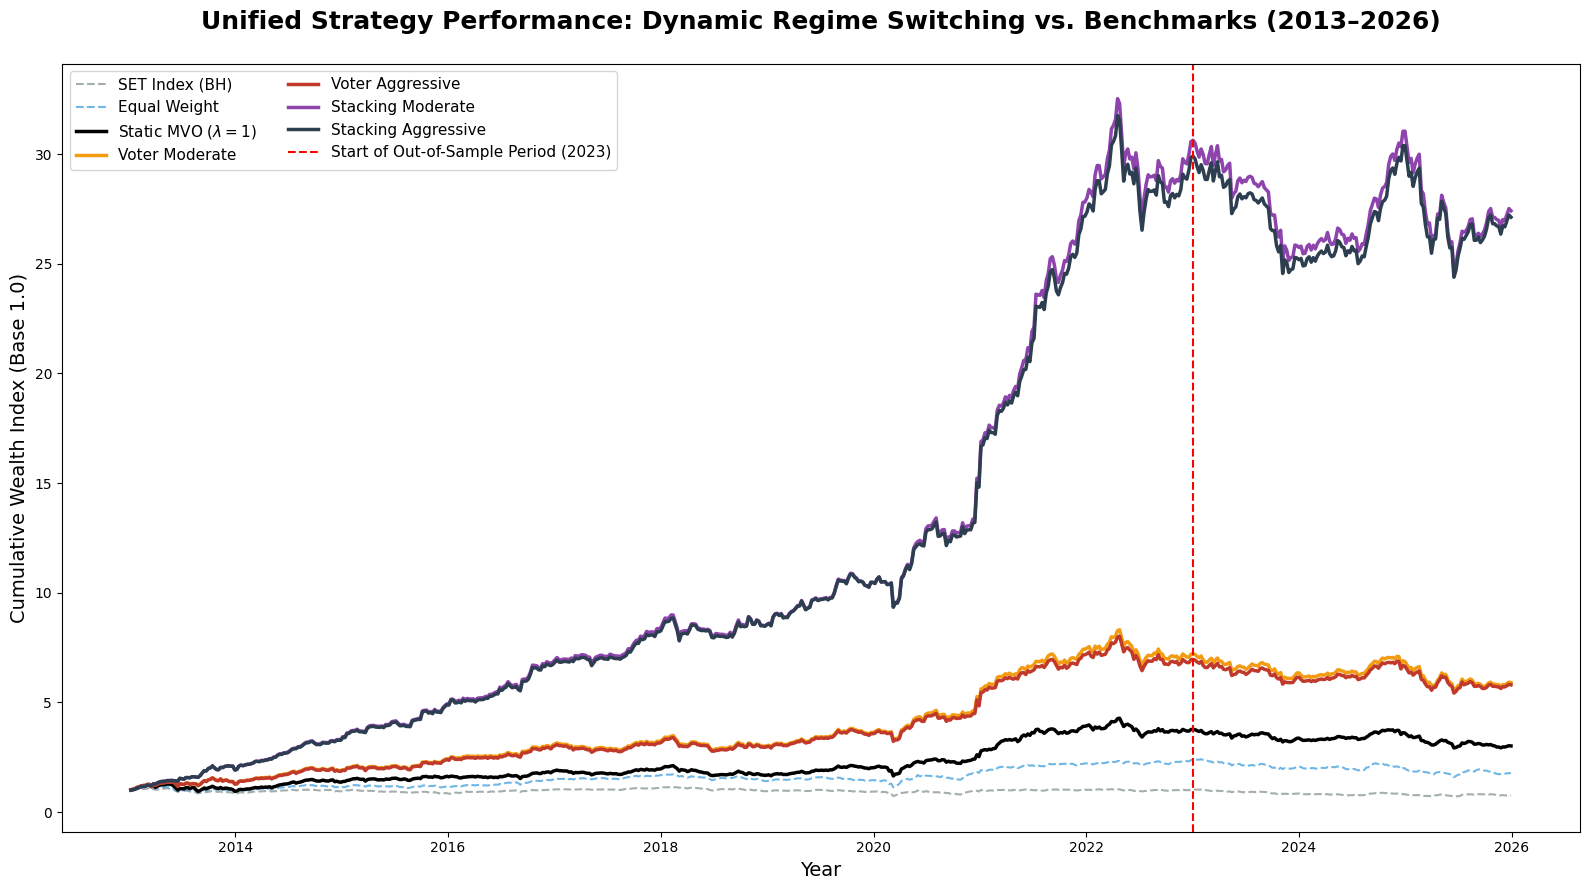

In [23]:
# 1. Calculate Cumulative Growth
df_cum_final = (1 + df_portfolio_returns).cumprod()

# 2. Define Display Names
display_names = {
    'SET_Index_BH': 'SET Index (BH)',
    'Equal_Weight': 'Equal Weight',
    'Static_MVO_Lambda_1': 'Static MVO ($\\lambda=1$)',
    'Voter_Moderate': 'Voter Moderate',
    'Voter_Aggressive': 'Voter Aggressive',
    'Stacking_Moderate': 'Stacking Moderate',
    'Stacking_Aggressive': 'Stacking Aggressive'
}

# 3. High-Contrast Research Palette
colors = {
    'SET_Index_BH': '#7f8c8d',
    'Equal_Weight': '#3498db',
    'Static_MVO_Lambda_2': '#27ae60',
    'Voter_Moderate': '#f39c12',
    'Voter_Aggressive': '#c0392b',
    'Stacking_Moderate': '#8e44ad',
    'Stacking_Aggressive': '#2c3e50'
}

# 4. Initialize Plot
plt.figure(figsize=(16, 9))

# 5. Iterative Plotting with Visual Hierarchy
for col in df_cum_final.columns:
    label = display_names.get(col, col)

    if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2']:
        plt.plot(df_cum_final[col],
                 label=label, color=colors.get(col, '#000000'),
                 alpha=0.7, linestyle='--', linewidth=1.5)
    else:
        plt.plot(df_cum_final[col],
                 label=label, color=colors.get(col, '#000000'),
                 alpha=1.0, linestyle='-', linewidth=2.5)

# 6. PERIOD MARKER: Vertical Line for 2023 Start
try:
    # Identify the first data point of 2023 for the marker
    test_start_date = df_cum_final.loc['2023'].index[0]
    plt.axvline(x=test_start_date, color='red', linestyle='--',
                linewidth=1.5, label='Start of Out-of-Sample Period (2023)')
except Exception as e:
    print(f"Marker Error: {e}")

# 7. Formatting for Research Publication
plt.title('Unified Strategy Performance: Dynamic Regime Switching vs. Benchmarks (2013–2026)',
          fontsize=18, fontweight='bold', pad=25)
plt.ylabel('Cumulative Wealth Index (Base 1.0)', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Multi-column legend for clarity
plt.legend(loc='upper left', frameon=True, fontsize=11, ncol=2)

# Professional Finish: Clean background
plt.grid(False)
plt.tight_layout()

plt.show()

# Export Portfolio results

In [24]:
# Final Export Command - Including Date Index
if True:  # set as true to export csv
    df_portfolio_returns.to_csv('portfolio_returns_final.csv', index=True)